# Распознавание болезней

Напишите классификацию заболеваний по базе симптомов, используя любые подходы, связанные с обработкой текстов.

Добейтесь максимальной точности распознавания.

Используйте xLen = 50.

## Подготовка данных

### Import библиотек

In [ ]:
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
# "Магическая"команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Загрузка данных


In [ ]:
###########################
# Чтение файла в текст
##########################
def readText(fileName): # функция принимает имя файла
  f = open(fileName, 'r')        # задаем открытие нужного файла в режиме чтения
  text = f.read()                # читаем текст
  text = text.replace("\n", " ") # переносы строки переводим в пробелы
  
  return text                    # функция возвращает текст файла

# Загружаем обучающие тексты
trainText = []
trainText.append(readText('/content/drive/MyDrive/Базы/Болезни/Аппендицит.txt'))
trainText.append(readText('/content/drive/MyDrive/Базы/Болезни/Гастрит.txt'))
trainText.append(readText('/content/drive/MyDrive/Базы/Болезни/Гепатит.txt'))
trainText.append(readText('/content/drive/MyDrive/Базы/Болезни/Дуоденит.txt'))
trainText.append(readText('/content/drive/MyDrive/Базы/Болезни/Колит.txt'))
trainText.append(readText('/content/drive/MyDrive/Базы/Болезни/Панкреатит.txt'))
trainText.append(readText('/content/drive/MyDrive/Базы/Болезни/Холицестит.txt')) 
trainText.append(readText('/content/drive/MyDrive/Базы/Болезни/Эзофагит.txt')) 
trainText.append(readText('/content/drive/MyDrive/Базы/Болезни/Энтерит.txt')) 
trainText.append(readText('/content/drive/MyDrive/Базы/Болезни/Язва.txt'))  

className = ["Аппендицит", "Гастрит", "Гепатит", "Дуоденит", "Колит", "Панкреатит","Холицестит", "Эзофагит", "Энтерит", "Язва"]
nClasses = len(className)

# Загружаем тестовые тексты
testText = []
testText.append(readText('/content/drive/MyDrive/Базы/Болезни/Аппендицит.txt')[:1000])
testText.append(readText('/content/drive/MyDrive/Базы/Болезни/Гастрит.txt')[:1000])
testText.append(readText('/content/drive/MyDrive/Базы/Болезни/Гепатит.txt')[:1000])
testText.append(readText('/content/drive/MyDrive/Базы/Болезни/Дуоденит.txt')[:1000])
testText.append(readText('/content/drive/MyDrive/Базы/Болезни/Колит.txt')[:1000])
testText.append(readText('/content/drive/MyDrive/Базы/Болезни/Панкреатит.txt')[:1000])
testText.append(readText('/content/drive/MyDrive/Базы/Болезни/Холицестит.txt')[:1000]) 
testText.append(readText('/content/drive/MyDrive/Базы/Болезни/Эзофагит.txt')[:1000]) 
testText.append(readText('/content/drive/MyDrive/Базы/Болезни/Энтерит.txt')[:1000]) 
testText.append(readText('/content/drive/MyDrive/Базы/Болезни/Язва.txt')[:1000]) 

### Обработка данных


In [ ]:
# ВАЖНО! ВСЕ СИМПТОМЫ ПОСТУПАЮТ В ОБУЧАЮЩУЮ ВЫБОРКУ. В ТЕСТОВУЮ БЕРЕМ ТОЛЬКО ЧАСТЬ.
# 

# Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью


maxWordsCount = 20000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

# для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(trainText) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:100]) # взглянем на содержимое словаря

[('unknown', 1), ('в', 2), ('и', 3), ('боль', 4), ('тошнота', 5), ('или', 6), ('рвота', 7), ('боли', 8), ('живота', 9), ('при', 10), ('животе', 11), ('после', 12), ('области', 13), ('отрыжка', 14), ('с', 15), ('слабость', 16), ('аппетита', 17), ('во', 18), ('тела', 19), ('изжога', 20), ('вздутие', 21), ('может', 22), ('снижение', 23), ('пищи', 24), ('повышение', 25), ('температуры', 26), ('рту', 27), ('еды', 28), ('диарея', 29), ('на', 30), ('иногда', 31), ('до', 32), ('к', 33), ('метеоризм', 34), ('температура', 35), ('подреберье', 36), ('верхней', 37), ('части', 38), ('не', 39), ('правом', 40), ('стул', 41), ('потеря', 42), ('чувство', 43), ('общая', 44), ('эпигастральной', 45), ('желудка', 46), ('урчание', 47), ('ощущение', 48), ('отсутствие', 49), ('ощущения', 50), ('понос', 51), ('нарушение', 52), ('позывы', 53), ('тяжести', 54), ('которая', 55), ('запор', 56), ('время', 57), ('приема', 58), ('кожи', 59), ('могут', 60), ('появление', 61), ('повышенная', 62), ('эпигастрии', 63), ('

In [ ]:
print("Протестируем словарь частотности")
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("уточните слово: ")]) #протестируем словарь частотности

Протестируем словарь частотности
уточните слово: болезни
Интересующее слово имеет индекс:  458


In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1] [:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20])

print()
print()

print("Статистика по обучающим текстам:")
for i in range(10):
  print(className[i], " ", len(trainText[i]), " символов, ", len(trainWordIndexes[i]), " слов")
print("В сумме ", len(trainText[0])+len(trainText[1])+len(trainText[2])+len(trainText[3])+len(trainText[4])+len(trainText[5])+len(trainText[6])+len(trainText[7])+len(trainText[8])+len(trainText[9]), " символов, ", len(trainWordIndexes[0])+len(trainWordIndexes[1])+len(trainWordIndexes[2])+len(trainWordIndexes[3])+len(trainWordIndexes[4])+len(trainWordIndexes[5])+len(trainWordIndexes[6])+len(trainWordIndexes[7])+len(trainWordIndexes[8])+len(trainWordIndexes[9]), " слов")
print()
print("Статистика по проверочным текстам:")
for i in range(10):
  print(className[i], " ", len(testText[i]), " символов, ", len(testWordIndexes[i]), " слов")
print("В сумме ", len(testText[0])+len(testText[1])+len(testText[2])+len(testText[3])+len(testText[4])+len(testText[5])+len(testText[6])+len(testText[7])+len(testText[8])+len(testText[9]), " символов, ", len(testWordIndexes[0])+len(testWordIndexes[1])+len(testWordIndexes[2])+len(testWordIndexes[3])+len(testWordIndexes[4])+len(testWordIndexes[5])+len(testWordIndexes[6])+len(testWordIndexes[7])+len(testWordIndexes[8])+len(testWordIndexes[9]), " слов")
print()

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               ГАСТРИТ СИМПТОМЫ  диспепсии (тяжесть и чувство давления, полноты в подложечной области,
Он же в виде последовательности индексов:  [590, 129, 335, 65, 3, 43, 99, 591, 2, 160, 13, 14, 336, 5, 66, 102, 18, 27, 147, 2]


Статистика по обучающим текстам:
Аппендицит   4075  символов,  579  слов
Гастрит   6717  символов,  839  слов
Гепатит   5523  символов,  687  слов
Дуоденит   3941  символов,  488  слов
Колит   9127  символов,  1192  слов
Панкреатит   11313  символов,  1480  слов
Холицестит   6157  символов,  841  слов
Эзофагит   5867  символов,  793  слов
Энтерит   6383  символов,  828  слов
Язва   3460  символов,  472  слов
В сумме  62563  символов,  8199  слов

Статистика по проверочным текстам:
Аппендицит   1000  символов,  142  слов
Гастрит   1000  символов,  121  слов
Гепатит   1000  символов,  128  слов
Дуоденит   1000  символов,  112  слов
Колит   1000  символов,  128  слов
Панкреатит   1000  символо

In [ ]:
len(trainWordIndexes)

10

In [ ]:
len(testWordIndexes)

10

### Создание обучающей и проверочной выборки

**Функции для формирования выборки по отрезкам текста с заданным шагом**

In [ ]:
#
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
#
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  # Идём по всей длине вектора индексов
  # "Откусываем" векторы длины xLen и смещаеммся вперёд на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

In [ ]:
#
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
#
def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 10 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна(например 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses):  # в диапазоне кол-ва классов(6)
    xT = classesXSamples[t]  # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range(len(xT)): # и каждое его окно
      xSamples.append(xT[i]) # добавляем в общий список выборки
    
    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)): # на каждое окно выборки 
      ySamples.append(currY) # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

**Подготовка данных**

In [ ]:
# Задаём базовые параметры
xLen = 100 # Длина отрезка текста, по которой анализируем, в словах
step = 10 # Шаг разбиения исходного текста на обучающие вектора

In [ ]:
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(725, 100)
(725, 10)
(38, 100)
(38, 10)


### Распознавание проверочной выборки


In [ ]:
#
# Представляем тестовую выборку в удобных для распознавания размерах
#
def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов
  xTest6Classes01 = []               # здесь будет список из всех классов,каждый размером "кол-во окон в тексте * 20000(при maxWordsCount=20000)"
  xTest6Classes = []                 # здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(10 по 420*1000)
  for wI in wordIndexes:             # для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) # тестовая выборка размером "кол-во окон*длину окна"(например 420*1000)
    xTest6Classes.append(np.array(sample))       # переводим в массив numpy и добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) # трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     # и добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes # функция вернёт тестовые данные: TestBg 10 классов на n*20000 и xTestEm 10 по n*1000

#
# Расспознаём тестовую выборку и выводим результаты
#
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    
    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


## Эксперименты

1. Embedding + Dense сеть.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 14)           280000    
                                                                 
 batch_normalization_1 (Batc  (None, 100, 14)          56        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 100, 14)           0         
                                                                 
 flatten_1 (Flatten)         (None, 1400)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                14010     
                                                                 
Total params: 294,066
Trainable params: 294,038
Non-trainable params: 28
_______________________________________________

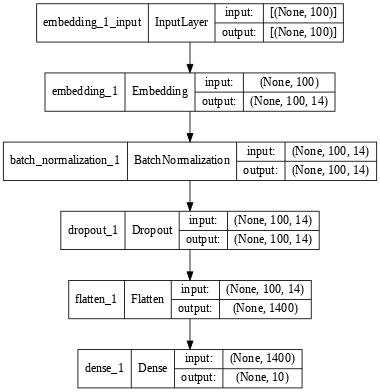

In [ ]:
modelED = Sequential()
modelED.add(Embedding(maxWordsCount, 14, input_length=xLen))
modelED.add(BatchNormalization())
modelED.add(Dropout(0.25))
modelED.add(Flatten())
modelED.add(Dense (10, activation="softmax"))

modelED.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

modelED.summary()
print()
plot_model(modelED, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
history = modelED.fit(xTrain,
                      yTrain,
                      epochs=50,
                      batch_size=512,
                      validation_data=(xTest, yTest))

Epoch 1/50
2/2 [==============================] - 0s 78ms/step - loss: 0.0585 - accuracy: 1.0000 - val_loss: 2.0620 - val_accuracy: 0.3947
Epoch 2/50
2/2 [==============================] - 0s 43ms/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 2.0514 - val_accuracy: 0.3684
Epoch 3/50
2/2 [==============================] - 0s 50ms/step - loss: 0.0405 - accuracy: 1.0000 - val_loss: 2.0415 - val_accuracy: 0.3947
Epoch 4/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 2.0325 - val_accuracy: 0.3947
Epoch 5/50
2/2 [==============================] - 0s 43ms/step - loss: 0.0315 - accuracy: 1.0000 - val_loss: 2.0220 - val_accuracy: 0.4474
Epoch 6/50
2/2 [==============================] - 0s 47ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 2.0133 - val_accuracy: 0.4737
Epoch 7/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 2.0035 - val_accuracy: 0.5263
Epoch 8/50
2/2 [===========

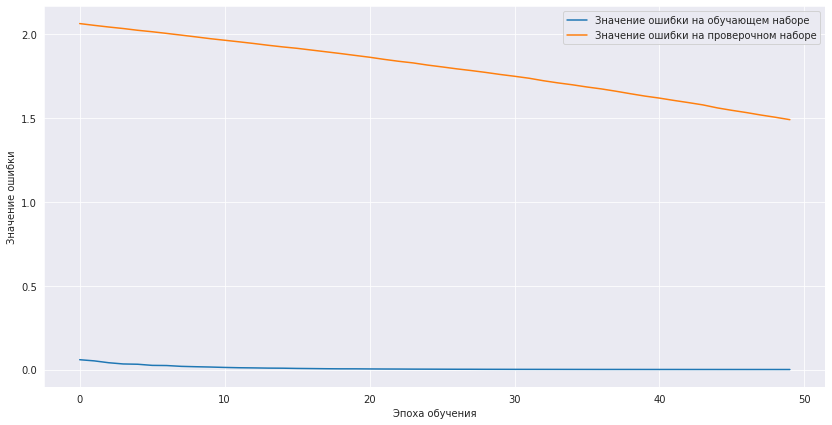

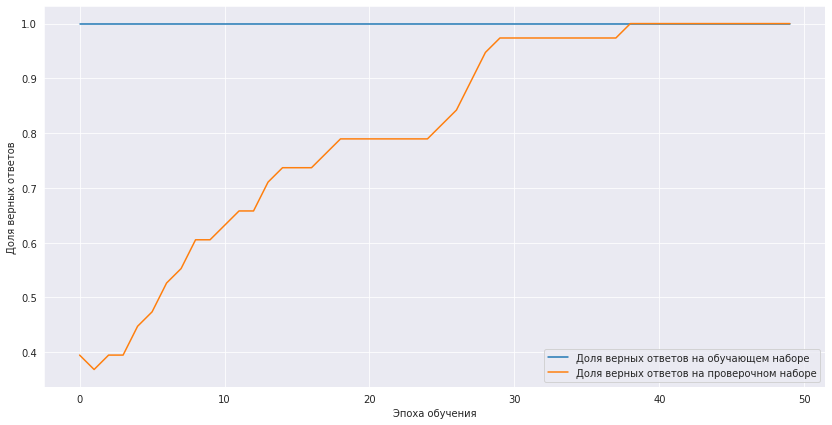

In [ ]:
# Строим график отображения динамики ошибки работы модели
plt.figure(figsize = (14,7))
plt.plot(history.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# График отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred=recognizeMultiClass(modelED, xTest6Classes, 'ED') # функция покажет, какие классы и как распознаны верно

НЕЙРОНКА:  ED

Аппендицит  распознано  100 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  100 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  100 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  100 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  100 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  100 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  100 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  100 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  100 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  100 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  100 %



2. Embedding + LSTM сеть.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 20)           400000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 100, 20)          0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_6 (Batc  (None, 100, 20)          80        
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (None, 10)                1240      
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
Total params: 401,430
Trainable params: 401,390
Non-tr

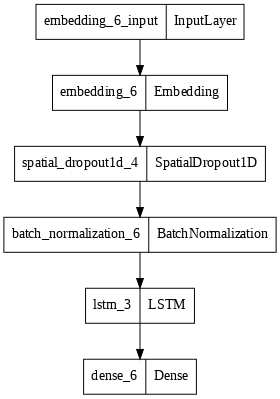

In [ ]:
modelELS = Sequential()
modelELS.add(Embedding(maxWordsCount, 20, input_length=xLen))
modelELS.add(SpatialDropout1D(0.35))  # слой регуляризации, "выключающий" 1D карты объектов из Embedding векторов, во избежание переобучения
modelELS.add(BatchNormalization())
modelELS.add(LSTM(10))
modelELS.add(Dense (10, activation="softmax"))

modelELS.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

modelELS.summary()
print()
plot_model(modelELS, dpi=70) # Выводим схему модели

In [ ]:
history = modelELS.fit(xTrain,
                      yTrain,
                      epochs=50,
                      batch_size=512,
                      validation_data=(xTest, yTest))

Epoch 1/50
2/2 [==============================] - 0s 129ms/step - loss: 0.9765 - accuracy: 0.8083 - val_loss: 1.9805 - val_accuracy: 0.3684
Epoch 2/50
2/2 [==============================] - 0s 96ms/step - loss: 0.9584 - accuracy: 0.8083 - val_loss: 1.9471 - val_accuracy: 0.3684
Epoch 3/50
2/2 [==============================] - 0s 100ms/step - loss: 0.9462 - accuracy: 0.8193 - val_loss: 1.9572 - val_accuracy: 0.2895
Epoch 4/50
2/2 [==============================] - 0s 100ms/step - loss: 0.9292 - accuracy: 0.8028 - val_loss: 2.0138 - val_accuracy: 0.2105
Epoch 5/50
2/2 [==============================] - 0s 95ms/step - loss: 0.9099 - accuracy: 0.8303 - val_loss: 1.9728 - val_accuracy: 0.2105
Epoch 6/50
2/2 [==============================] - 0s 100ms/step - loss: 0.8965 - accuracy: 0.8262 - val_loss: 2.0208 - val_accuracy: 0.2105
Epoch 7/50
2/2 [==============================] - 0s 102ms/step - loss: 0.8865 - accuracy: 0.8248 - val_loss: 2.0431 - val_accuracy: 0.1842
Epoch 8/50
2/2 [======

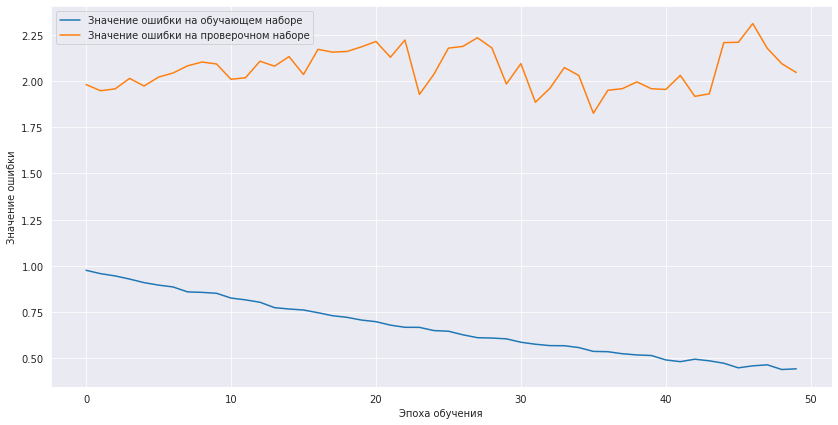

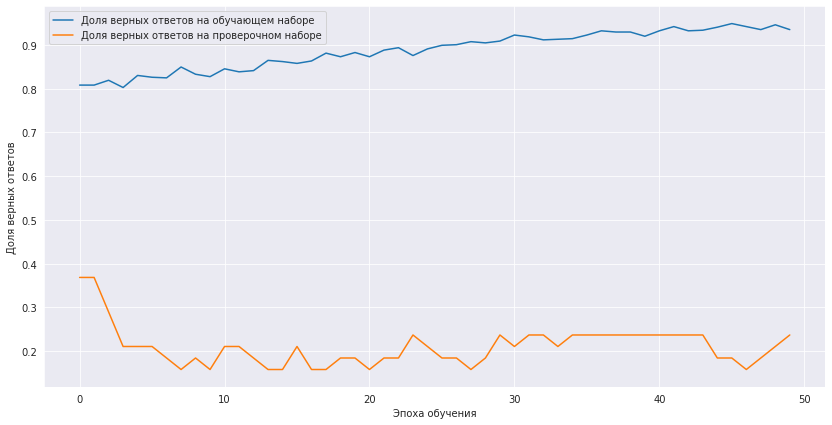

In [ ]:
# Строим график отображения динамики ошибки работы модели
plt.figure(figsize = (14,7))
plt.plot(history.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# График отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred=recognizeMultiClass(modelELS, xTest6Classes, 'Embedding и LSTM') # функция покажет, какие классы и как распознаны верно

НЕЙРОНКА:  Embedding и LSTM

Аппендицит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гастрит  распознано  0 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  0 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!
Колит  распознано  0 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  100 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  0 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  100 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  23 %



3. Embedding + Conv1D сеть.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 20)           400000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 100, 20)          0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_5 (Batc  (None, 100, 20)          80        
 hNormalization)                                                 
                                                                 
 conv1d (Conv1D)             (None, 100, 20)           2020      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 20)           0         
 )                                                               
                                                      

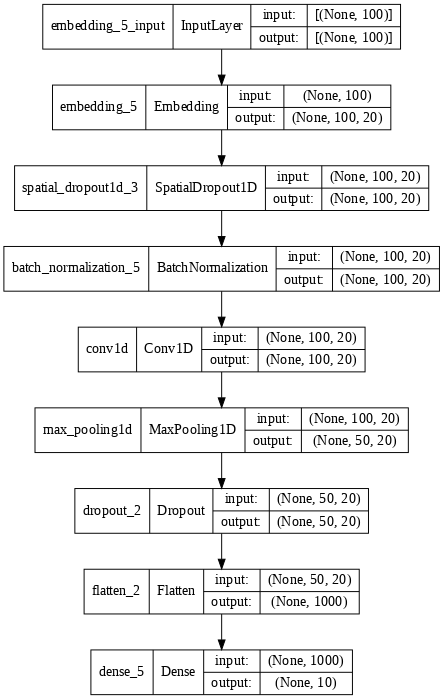

In [ ]:
modelEC_1 = Sequential()
modelEC_1.add(Embedding(maxWordsCount, 20, input_length=xLen))
modelEC_1.add(SpatialDropout1D(0.25))
modelEC_1.add(BatchNormalization())
modelEC_1.add(Conv1D(20,5, activation='relu', padding='same')) # одномерный сверточный слой с указанием количества фильтров и ширины окна для фильтров
modelEC_1.add(MaxPooling1D(2))
modelEC_1.add(Dropout(0.25))
modelEC_1.add(Flatten())
modelEC_1.add(Dense(10, activation='softmax'))

modelEC_1.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

modelEC_1.summary()
print()
plot_model(modelEC_1, dpi=70, show_shapes=True)

In [ ]:
history = modelEC_1.fit(xTrain,
                      yTrain,
                      epochs=20,
                      batch_size=512,
                      validation_data=(xTest, yTest))

Epoch 1/20
2/2 [==============================] - 1s 248ms/step - loss: 2.7666 - accuracy: 0.1117 - val_loss: 2.2950 - val_accuracy: 0.2368
Epoch 2/20
2/2 [==============================] - 0s 54ms/step - loss: 2.2978 - accuracy: 0.2055 - val_loss: 2.2861 - val_accuracy: 0.3947
Epoch 3/20
2/2 [==============================] - 0s 58ms/step - loss: 2.0748 - accuracy: 0.2566 - val_loss: 2.2792 - val_accuracy: 0.4474
Epoch 4/20
2/2 [==============================] - 0s 61ms/step - loss: 1.8878 - accuracy: 0.3407 - val_loss: 2.2732 - val_accuracy: 0.5263
Epoch 5/20
2/2 [==============================] - 0s 72ms/step - loss: 1.8280 - accuracy: 0.3738 - val_loss: 2.2663 - val_accuracy: 0.6316
Epoch 6/20
2/2 [==============================] - 0s 61ms/step - loss: 1.6365 - accuracy: 0.4593 - val_loss: 2.2606 - val_accuracy: 0.6579
Epoch 7/20
2/2 [==============================] - 0s 55ms/step - loss: 1.4858 - accuracy: 0.5434 - val_loss: 2.2519 - val_accuracy: 0.7895
Epoch 8/20
2/2 [==========

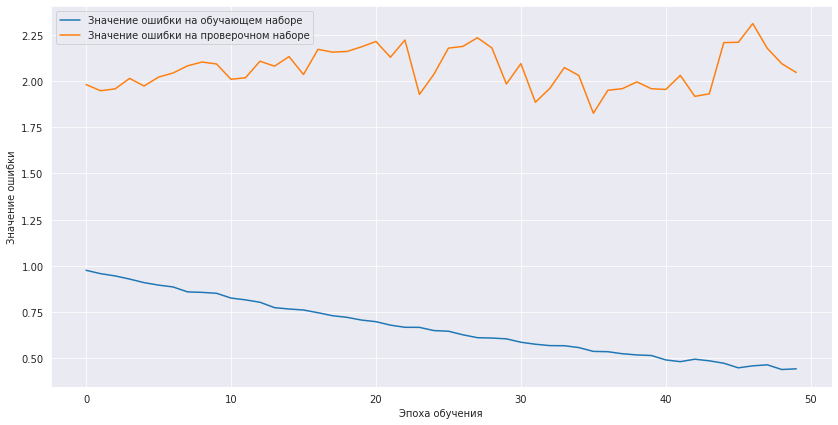

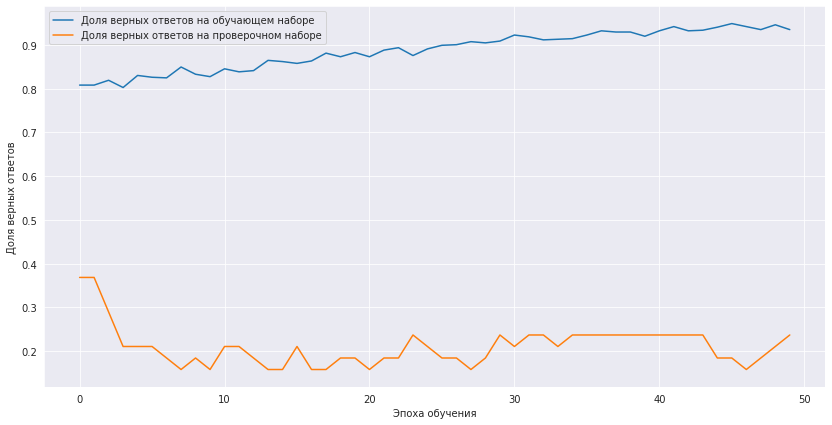

In [ ]:
# Строим график отображения динамики ошибки работы модели
plt.figure(figsize = (14,7))
plt.plot(history.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# График отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred=recognizeMultiClass(modelEC_1, xTest6Classes, 'Embedding и Dense') # функция покажет, какие классы и как распознаны верно

НЕЙРОНКА:  Embedding и Dense

Аппендицит  распознано  100 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  100 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  100 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  100 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  100 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  100 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  100 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  100 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  100 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  100 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  100 %



4. Embedding + сложная сеть из Dense, LSTM и Conv1D.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 50)           1000000   
                                                                 
 dense_11 (Dense)            (None, 100, 100)          5100      
                                                                 
 dropout_10 (Dropout)        (None, 100, 100)          0         
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 100, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 100, 14)           6440      
                                                                 
 dropout_11 (Dropout)        (None, 100, 14)           0         
                                                      

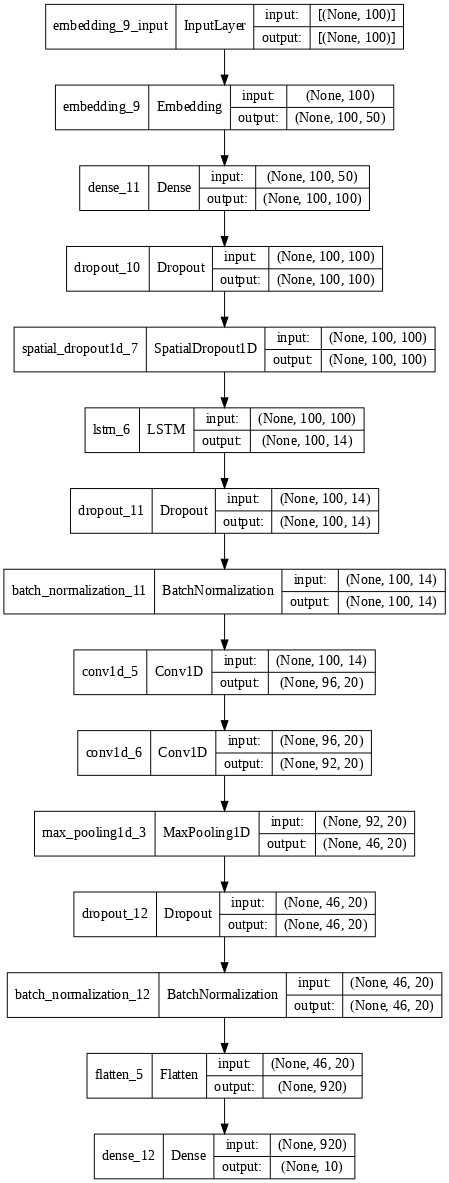

In [ ]:
modelDLC_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelDLC_1.add(Embedding(maxWordsCount, 50, input_length=xLen))
modelDLC_1.add(Dense(100, activation='relu'))
modelDLC_1.add(Dropout(0.25))
modelDLC_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelDLC_1.add(LSTM(14, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelDLC_1.add(Dropout(0.2))
modelDLC_1.add(BatchNormalization())
modelDLC_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
modelDLC_1.add(Conv1D(20, 5, activation="relu")) 
modelDLC_1.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
modelDLC_1.add(Dropout(0.2)) 
modelDLC_1.add(BatchNormalization()) 
modelDLC_1.add(Flatten())
modelDLC_1.add(Dense(10, activation='softmax'))

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelDLC_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelDLC_1.summary()
print()
plot_model(modelDLC_1, dpi=70,  show_shapes=True)

In [ ]:
history = modelDLC_1.fit(xTrain,
                      yTrain,
                      epochs=20,
                      batch_size=512,
                      validation_data=(xTest, yTest))

Epoch 1/20
2/2 [==============================] - 5s 855ms/step - loss: 3.1035 - accuracy: 0.1021 - val_loss: 2.3005 - val_accuracy: 0.1053
Epoch 2/20
2/2 [==============================] - 0s 179ms/step - loss: 2.6886 - accuracy: 0.1572 - val_loss: 2.2983 - val_accuracy: 0.1842
Epoch 3/20
2/2 [==============================] - 0s 181ms/step - loss: 2.3567 - accuracy: 0.2290 - val_loss: 2.2960 - val_accuracy: 0.1053
Epoch 4/20
2/2 [==============================] - 0s 178ms/step - loss: 2.0364 - accuracy: 0.3048 - val_loss: 2.2934 - val_accuracy: 0.1053
Epoch 5/20
2/2 [==============================] - 0s 189ms/step - loss: 1.8191 - accuracy: 0.3917 - val_loss: 2.2894 - val_accuracy: 0.1053
Epoch 6/20
2/2 [==============================] - 0s 180ms/step - loss: 1.5053 - accuracy: 0.4828 - val_loss: 2.2832 - val_accuracy: 0.1316
Epoch 7/20
2/2 [==============================] - 0s 187ms/step - loss: 1.2766 - accuracy: 0.5628 - val_loss: 2.2815 - val_accuracy: 0.1842
Epoch 8/20
2/2 [====

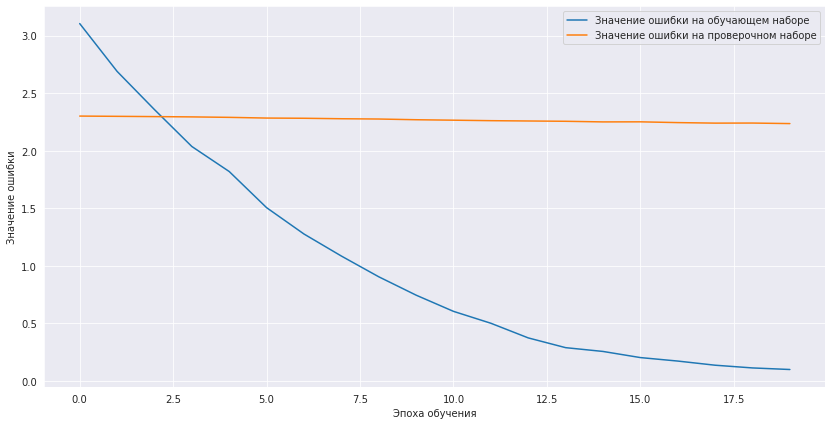

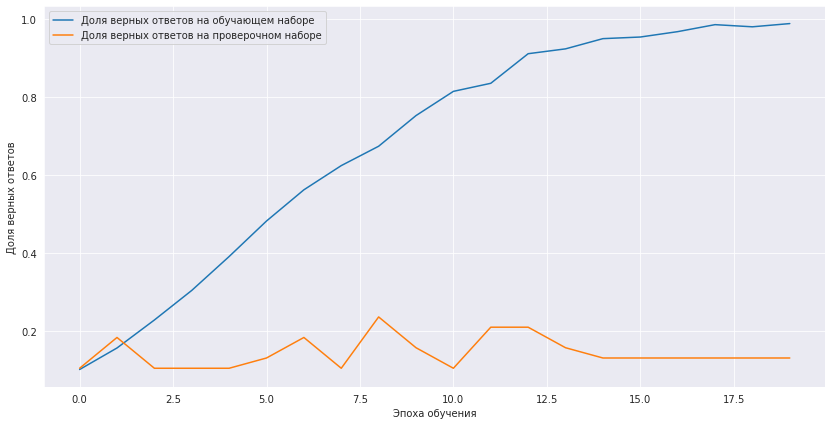

In [ ]:
# Строим график отображения динамики ошибки работы модели
plt.figure(figsize = (14,7))
plt.plot(history.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# График отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14,7))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred=recognizeMultiClass(modelDLC_1, xTest6Classes, 'Embedding и Dense') # функция покажет, какие классы и как распознаны верно

НЕЙРОНКА:  Embedding и Dense

Аппендицит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гастрит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Холицестит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Энтерит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Язва  распознано  100 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  13 %



Общий вывод: применение LSTM уничтожает работоспособность нейронки зачастую даже ниже уровня простой комбинаторики. Без LSTM точность 100 % обеспечивается вполне быстрым обучением.